# Supernova Data Analysis with ADVI

Loading the required packages

In [1]:
import jax
import jax.numpy as jnp
import jax.random as random

import jax_cosmo as jc

import numpyro
from numpyro import sample
import numpyro.distributions as dist
from numpyro.infer.autoguide import AutoMultivariateNormal
from numpyro.infer import init_to_value, Trace_ELBO, SVI
from optax import adam

import matplotlib.pyplot as plt

import arviz as az

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


Generate random keys for jax random numbers

In [2]:
key = random.PRNGKey(3141)
key, subkey, subkey2, subkey3 = random.split(key, 4)

## Creating some data

The distance modulus $\mu$ is given through the following equation

\begin{equation}
    25 + 5 \log_{10}\left( \frac{d_L}{\text{Mpc}} \right),
\end{equation}

where $d_L$ is the distance modulus. It is related to the angular diameter distance $d_A$ via

\begin{equation}
    d_L/\text{[Mpc]} = \frac{d_A/\text{[Mpc/h]}}{h a^2},
\end{equation}

where $d_A$ is included in jax_cosmo and returned in units of [Mpc/h].

$a$ is the universe's scale parameter and related with the redshift parameter $z$ through $a = 1/(1+z)$

In [3]:
shape = (2000,)
z_random = random.uniform(key, shape, minval=0.01, maxval=1.5)
z = jnp.sort(z_random)

In [4]:
true_param = {'h':0.7,
    'Omega_m':0.29,
    'w0':-1.02,
    'wa':0.01}

In [5]:
def distance_modulus(theta, z):
    a = jc.utils.z2a(z)
    h = theta.get('h', 0.7)
    Omega_m = theta.get('Omega_m', 0.3)
    Omega_b = 0.05
    Omega_c = Omega_m - Omega_b
    Omega_k = theta.get('Omega_k', 0.)
    w0 = theta.get('w0', -1.)
    wa = theta.get('wa', 0.)
    
    cosmology = jc.Cosmology(h=h, Omega_c=Omega_c, Omega_b=Omega_b, w0=w0, wa=wa, Omega_k=Omega_k, n_s=0.96, sigma8=0.83)
    dist_L = (jc.background.angular_diameter_distance(cosmology, a)/a**2.0)/h
    dist_mod = 25. + 5. * jnp.log10(dist_L)
    return dist_mod

Random noise can be added at this point.

In [81]:
sigma = 0.3 * jnp.log(1+z)
dist_mod_err = sigma * random.normal(subkey, shape) 

cov = jnp.diag(sigma**2)

In [82]:
dist_mod = distance_modulus(true_param, z) #+ dist_mod_err

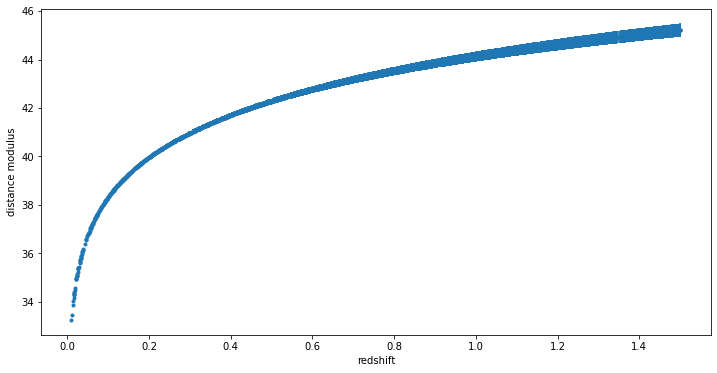

In [83]:
plt.figure(figsize=(12,6))
plt.errorbar(z, dist_mod, yerr = sigma, marker='.', linestyle='')
plt.xlabel('redshift')
plt.ylabel('distance modulus');

## Setting up the model

In [84]:
def model_cpl():
    Omega_m = sample("Omega_m", dist.Uniform(0,1))
    w0 = sample("w0", dist.Uniform(-10, 10))
    wa = sample("wa", dist.Uniform(-10,10))
    theta_dict = {"Omega_m":Omega_m, "w0":w0, "wa":wa}
    mu = distance_modulus(theta_dict, z)
    
    sample("y", dist.MultivariateNormal(mu, cov), obs=dist_mod)

## Running the optimizer

In [85]:
initial_values = {'Omega_m':0.3, 'w0':-1., 'wa':0.}

In [86]:
guide_cpl = AutoMultivariateNormal(model_cpl, 
                                   init_loc_fn = init_to_value(values=initial_values))

In [87]:
svi = SVI(model_cpl, 
    guide_cpl, 
    adam(0.005), 
    Trace_ELBO()
)

In [88]:
svi_result = svi.run(subkey2, 20000)

/home/jakob/.local/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:4459: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax_internal._check_user_dtype_supported(dtype, "astype")
100%|███████████████| 20000/20000 [24:26<00:00, 13.64it/s, init loss: -1350.2955, avg. loss [19001-20000]: -2248.8694]


### Evaluating the result
The posterior samples get converted into arviz inference data.

In [89]:
samples = guide_cpl.sample_posterior(subkey3, svi_result.params, (1000000,))
idata_num = az.from_dict(samples)

In [90]:
az.summary(idata_num, kind='stats')

,mean,sd,hdi_3%,hdi_97%
Omega_m,0.311,0.019,0.276,0.348
w0,-1.056,0.026,-1.104,-1.007
wa,-0.277,0.248,-0.741,0.192


## Plotting

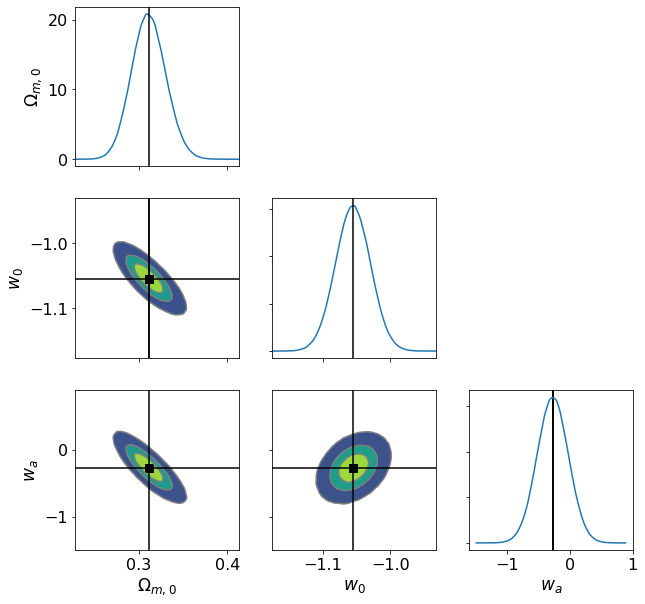

In [91]:
var_dict = {"Omega_m" : r"$\Omega_{m,0}$",
               "w0" :  r"$w_0$",
               "wa" : r"$w_a$"}   

labeller = az.labels.MapLabeller(var_name_map=var_dict)

az.plot_pair(idata_num, 
             kind='kde', 
             marginals=True, 
             figsize=(10,10), 
             textsize=16, 
             contour=False, 
             labeller=labeller, 
             kde_kwargs = {'hdi_probs' : [0.3, 0.6, 0.9]},
             point_estimate = 'mean'
            );

(-2280.0, -2150.0)

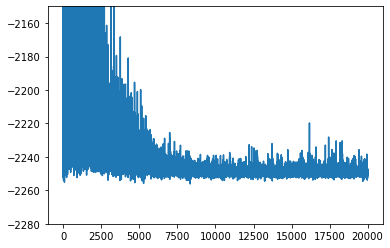

In [97]:
plt.plot(svi_result.losses)
plt.ylim(-2280, -2150)